#Video

[Video](https://drive.google.com/file/d/1Kdgahrwr9lGCyUzRjgvYbKy95glVNYQ-/view)

#Integrantes



*   Cristino Pérez Ramos
*   Mynor Gabriel López Méndez




#Scope

Este proyecto contiene dese la creación de una base de datos relacional de la venta de peliculas de una tienda, que forma parte del escenario ficticio sobre el cual se realizará un análisis de datos.  

La base de datos es creada desde 0, junto a datso de clientes, fechas de ventas y catalogo de peliculas que se venden en la tienda. Esta creación de escenario, se encuentra en el archivo [Escenario_Base_de_Datos](https://colab.research.google.com/drive/1tN4ElbrKJiy_9BBYaP1cBr76402BKsf3?usp=sharing). Todo esto fuera realizado en notebook de Google-Colab. 

Además, los archivos que alimentaban la base datos se encuentran en otras carpetas de este repositorio.   

Otra fuente de datos son los archivos alojados en ASW S3: Tales como:  Ventas de Febrero, y Ventas de Enero, junto con la dimensión de fecha para la creación.  De la estructura de los datos, se pude definir que lo mejor seria construir un Datawarehouse para la analitica a realizar. 


#ETL

##Instalación de librerias necesarias
Se realiza la instalación de librerias para manejo y conexion de consultas de Mysql con python.

In [ ]:
!pip install boto3
!pip install mysql-connector-python
!pip install pymysql 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Importamos las librerias necesarias.

In [ ]:
import pandas as pd
import numpy as np
import boto3
import io
import re
import psycopg2
import configparser
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as mysqlC

##Archivo de configuración
Se obtienen las credenciales que estan establecidas en el archivo de configuracion para la conexion hacia el servidor de AWS.

In [ ]:
config = configparser.ConfigParser()
config.read('escec_dataWarehouse.cfg')

['escec_dataWarehouse.cfg']

##RDS de la base de datos myMovieStore
Se establece el host para la conexion hacia el servidor AWS.

In [ ]:
RDS_HOST = 'mymoviestore.c6j34omip28z.us-east-2.rds.amazonaws.com'
#RDS_HOST=config.get('DW', 'RDS_HOST')
#RDS_HOST
print(RDS_HOST)

mymoviestore.c6j34omip28z.us-east-2.rds.amazonaws.com


In [ ]:
postgres_driver = f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""

#Creando Dimensiones

##Dimensión de Custumers

La creación de esta dimensión es bastante sencilla porque no tenemos necesidad de integrar otras tablas.

In [ ]:
sql_query = 'SELECT * FROM custumer;'
dim_custumer = pd.read_sql(sql_query, postgres_driver)
dim_custumer=dim_custumer.rename(columns={'Custumer type': 'custumer_type'})
dim_custumer.head()

,id_client,name,gender,custumer_type
0,1,Lora,Female,Member
1,2,Ambros,Male,Member
2,3,Mervin,Male,Member
3,4,Arliene,Female,Member
4,5,Aldous,Male,Member


##Dimensión Payment_Methods

La creación de esta dimensión también es directa desde la tabla.

In [ ]:
sql_query = 'SELECT * FROM payment_methods;'
dim_payment_methods = pd.read_sql(sql_query, postgres_driver)
dim_payment_methods.head()

,id_payment,name
0,1,Ewallet
1,2,Cash
2,3,Credit card


##Dimensión Movies

Esta dimensión es la más complicada de armar, porque existen otras tablas: categories,countries, y movie_type que necesitan ser integradas a la tabla movies.

In [ ]:
sql_query = 'SELECT * FROM movies;'
df_movies = pd.read_sql(sql_query, postgres_driver)
df_movies.head(3)

,show_id,type,title,director,casting,country,date_added,release_year,rating,duration,listed_in,description,price
0,1891,1,Qurious Como,Varios,Varios,0,2020-10-03,2017,TV-Y,1 Season,17,"Shrunk down in size, Como and his friends exam...",25
1,1892,2,A Chaster Marriage,Umut Kirca,"Emre Karayel, Ceren Moray, Begüm Kütük, Ececan...",76,2020-10-02,2016,TV-14,94 min,8,"Forced to wed his childhood friend, a man obse...",5
2,1893,2,A Go! Go! Cory Carson Halloween,Alex Woo,"Alan C. Lim, Smith Foreman, Maisie Benson, Ann...",0,2020-10-02,2020,TV-Y,22 min,5,"Cory, Chrissy and Freddie are on the hunt for ...",5


Incorporamos la tabla de los countries:

In [ ]:
sql_query = 'SELECT * FROM countries;'
df_countries = pd.read_sql(sql_query, postgres_driver)
df_countries = df_countries.rename(columns={'id_country': 'country', 'name': 'country_name'})
df_countries.head(3)

,country,country_name
0,0,Desconocido
1,1,Argentina
2,2,Australia


Uno los dataframes de movies con countries:

In [ ]:
df_movies_countries=df_movies.merge(df_countries, on='country', how='inner')
df_movies_countries =df_movies_countries.drop(['country'], axis=1)
df_movies_countries.tail(3)

,show_id,type,title,director,casting,date_added,release_year,rating,duration,listed_in,description,price,country_name
8804,7984,2,"Septiembre, un llanto en silencio",Kenneth Müller,"Saúl Lisazo, Mario Zaragoza, Juan Pablo Olysla...",2018-03-10,2017,TV-MA,69 min,12,"After a terrorist attack in Guatemala, a baby ...",5,Guatemala
8805,8074,2,Sprinter,Storm Saulter,"Dale Elliott, Kadeem Wilson, Dennis Titus, Dav...",2020-04-15,2018,TV-MA,112 min,12,When a Jamaican teen hopes to use track to reu...,5,Jamaica
8806,8457,2,The Pirates of Somalia,Bryan Buckley,"Evan Peters, Barkhad Abdi, Melanie Griffith, A...",2018-03-01,2017,R,118 min,12,An aspiring journalist travels to Somalia in h...,5,Somalia


Ahora es necesario combinarlo con la tabla de movie type.

In [ ]:
sql_query = 'SELECT * FROM movie_type;'
df_movie_type = pd.read_sql(sql_query, postgres_driver)
df_movie_type.head(3)

,id_type,name
0,1,TV Show
1,2,Movie


Le hacemos merge con la tabla que ya habiamos combinado: df_movies_countries

In [ ]:
df_movies = df_movies_countries.merge(df_movie_type, left_on='type',right_on='id_type', how='inner')
dim_movies = df_movies
dim_movies=dim_movies.drop(['type','id_type'], axis=1)
dim_movies = dim_movies.rename(columns={'show_id': 'id_movies','name': 'show_type'})
dim_movies.tail(3)

,id_movies,title,director,casting,date_added,release_year,rating,duration,listed_in,description,price,country_name,show_type
8804,7984,"Septiembre, un llanto en silencio",Kenneth Müller,"Saúl Lisazo, Mario Zaragoza, Juan Pablo Olysla...",2018-03-10,2017,TV-MA,69 min,12,"After a terrorist attack in Guatemala, a baby ...",5,Guatemala,Movie
8805,8074,Sprinter,Storm Saulter,"Dale Elliott, Kadeem Wilson, Dennis Titus, Dav...",2020-04-15,2018,TV-MA,112 min,12,When a Jamaican teen hopes to use track to reu...,5,Jamaica,Movie
8806,8457,The Pirates of Somalia,Bryan Buckley,"Evan Peters, Barkhad Abdi, Melanie Griffith, A...",2018-03-01,2017,R,118 min,12,An aspiring journalist travels to Somalia in h...,5,Somalia,Movie


Ahora es necesario combinarlo con la tabla de categories

In [ ]:
sql_query = 'SELECT * FROM categories;'
df_movie_cate = pd.read_sql(sql_query, postgres_driver)
df_movie_cate.head(3)

,id_category,name
0,1,Action & Adventure
1,2,Anime Features
2,3,Anime Series


In [ ]:
df_movies_cat = dim_movies.merge(df_movie_cate, left_on='listed_in', right_on='id_category', how='inner')
dim_movies = df_movies_cat
dim_movies = dim_movies.drop(['listed_in','id_category'], axis=1)
dim_movies = dim_movies.rename(columns={'name': 'category'})
dim_movies.tail(3)

,id_movies,title,director,casting,date_added,release_year,rating,duration,description,price,country_name,show_type,category
8804,1748,Prospect,Zeek Earl,"Sophie Thatcher, Pedro Pascal, Jay Duplass, An...",2020-11-02,2018,R,100 min,A father and daughter travel to an alien moon ...,5,Canada,Movie,Sci-Fi & Fantasy
8805,5968,'89,Varios,"Lee Dixon, Ian Wright, Paul Merson",2018-05-16,2017,TV-PG,87 min,"Mixing old footage with interviews, this is th...",5,Corea del Norte,Movie,Sports Movies
8806,2184,What Keeps You Alive,Colin Minihan,"Hannah Emily Anderson, Brittany Allen, Martha ...",2020-08-01,2018,R,99 min,A couple's romantic anniversary retreat to a r...,5,Canada,Movie,LGBTQ Movies


##Dimensión Ventas/Casi Tabla de Hechos

Nuestra tabla de ventas con la que contamos en la base de datos, solo contiene las ventas de una sucursal, especificamente del mes de marzo. Necesitamos juntar estos datos con las ventas de Enero y Febrero. Estos archivos se encuentran en S3

In [ ]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-2',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)

In [ ]:
for bucket in s3.buckets.all():
    S3_BUCKET_NAME = bucket.name
    print(bucket.name)

mymoviestore


Se establece el nombre del bucket especifico con el cual se obtendran los archivos necesarios.

In [ ]:
S3_BUCKET_NAME = 'mymoviestore'

Se obtienen todos los archivos que estan en el bucket

In [ ]:
remoteFileList = []
for objt in s3.Bucket(S3_BUCKET_NAME).objects.all():
    remoteFileList.append(objt.key)
remoteFileList

['Ch3-SampleDateDim 3.xlsx',
 'ventas/',
 'ventas/Transacciones_ventas_enero.csv',
 'ventas/Transacciones_ventas_febrero.csv']

##Transformación de data de ventas 

Obtenemos la data de las **ventas de Enero** y la guardamos en un DataFrame.

In [ ]:
file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFileList[2]).get()
data = file['Body'].read()
df_ventas_enero = pd.read_csv(io.BytesIO(data))
df_ventas_enero.head(3)

,id_ventas,movies_show_id,custumer_id_client,payment_methods_id_payment,total,fecha
0,1,357,148,1,15,1/1/2023
1,2,7082,265,3,40,1/1/2023
2,3,2512,187,2,5,1/1/2023


Leemos las **ventas de Febrero**

In [ ]:
file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFileList[3]).get()
data = file['Body'].read()
df_ventas_febrero= pd.read_csv(io.BytesIO(data))
df_ventas_febrero.head(3)

,id_ventas,movies_show_id,custumer_id_client,payment_methods_id_payment,total,fecha
0,1,252,178,2,35,2/1/2023
1,2,3170,216,1,40,2/1/2023
2,3,3838,238,2,35,2/1/2023


Incluimos las **ventas de Marzo**, que se encuentran en nuestra base de datos.

In [ ]:
sql_query = 'SELECT * FROM ventas;'
df_ventas_marzo = pd.read_sql(sql_query, postgres_driver)
df_ventas_marzo.head(3)

,id_ventas,movies_show_id,custumer_id_client,payment_methods_id_payment,total,fecha
0,1,2453,70,3,35,2023-03-01
1,2,4642,241,3,15,2023-03-01
2,3,5185,144,3,30,2023-03-01


Unimos todas las ventas de la tienda del año en un mismo data_frame Ventas

In [ ]:
df_ventas = pd.concat([df_ventas_enero,df_ventas_febrero,df_ventas_marzo])
df_ventas = df_ventas.rename(columns={'movies_show_id': 'id_movies', 'custumer_id_client': 'id_client','payment_methods_id_payment': 'id_payment'})

In [ ]:
df_ventas.head(5)

,id_ventas,id_movies,id_client,id_payment,total,fecha
0,1,357,148,1,15,1/1/2023
1,2,7082,265,3,40,1/1/2023
2,3,2512,187,2,5,1/1/2023
3,4,1493,9,1,40,1/1/2023
4,5,2590,56,1,45,1/1/2023


## Dimensión de Fecha
Leemos el documento de la dimension de fecha 2023 en formato excel

In [ ]:
file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFileList[0]).get()
data = file['Body'].read()
dim_fecha = pd.read_excel(io.BytesIO(data))
dim_fecha.head(3)

,date key,full date,day of week,day num in month,day num overall,day name,day abbrev,weekday flag,week num in year,week num overall,...,quarter,year,yearmo,fiscal month,fiscal quarter,fiscal year,month end flag,same day year ago,Unnamed: 24,table insert statement
0,20230101,2023-01-01,7,1,1,Sunday,Sun,Weekend,1,1,...,1,2023,202301,7,3,2023,Not Month End,2022-01-01,NaN,"insert into Date_Dimension values(20230101, '2..."
1,20230102,2023-01-02,1,2,2,Monday,Mon,Weekday,2,2,...,1,2023,202301,7,3,2023,Not Month End,2022-01-02,NaN,"insert into Date_Dimension values(20230102, '2..."
2,20230103,2023-01-03,2,3,3,Tuesday,Tue,Weekday,2,2,...,1,2023,202301,7,3,2023,Not Month End,2022-01-03,NaN,"insert into Date_Dimension values(20230103, '2..."


se hace la transformación de la data y se renombran las columnas para que se pueda insertar la data en la tabla de dimensión

In [ ]:
columnas=['date_key','full_date','day_of_week','day_num_in_month','day_num_overall','day_name','day_abbrev','weekday_flag','week_num_in_year','week_num_overall','week_begin_date','week_begin_date_key','month','month_num_overall','month_name','month_abbrev','quarter','year','yearmo','fiscal_month','fiscal_quarter','fiscal_year','last_day_in_month_flag','same_day_year_ago_date', 'sql1', 'sql2']
for i, columna in enumerate(dim_fecha.columns.tolist()):  
   dim_fecha = dim_fecha.rename(columns={columna:columnas[i]})
dim_fecha = dim_fecha.drop(['sql1','sql2'], axis=1)

##Tabla de hechos Fact Table

La Fact Table es casi la misma que lo que contiene la dimensión de ventas, la diferencia radica en que necesita ser un poco modificada.

In [ ]:
df_factTable = df_ventas

In [ ]:
df_ventas['year'] = pd.DatetimeIndex(df_ventas['fecha']).year
df_factTable['month'] = pd.DatetimeIndex(df_factTable['fecha']).strftime('%m')
df_factTable['day'] = pd.DatetimeIndex(df_factTable['fecha']).strftime('%d')
df_factTable['id_fecha'] = df_factTable['year'].astype(str) + df_factTable['month'].astype(str)
df_factTable['id_fecha'] = df_factTable['id_fecha'].astype(str) + df_factTable['day'].astype(str)
df_factTable.head(5)
df_factTable = df_factTable.drop(['year', 'month', 'day',  'fecha'], axis=1)


Ahora agregaré el indice del fact, de manera que sea autonumerica

In [ ]:
if 'id_fact' not in df_factTable.columns:
    df_factTable.reset_index(inplace=True)
    df_factTable.rename(columns={'index': 'id_fact'}, inplace=True)
    df_factTable['id_fact'] += 1
df_factTable = df_factTable.drop(['id_ventas'], axis=1)
length = len(df_factTable)
valores_id = range(1, length + 1)
df_factTable['id_fact'] = valores_id

Se verifican los duplicados datos que no pertenecen a la tabla de hechos

In [ ]:
duplicated_rows = df_factTable.duplicated(subset=["id_fact"])
df_factTable[duplicated_rows]
df_factTable = df_factTable.drop_duplicates(subset=["id_fact"]).loc[df_factTable['id_movies'] < len(dim_movies)]
df_factTable.head(3)

,id_fact,id_movies,id_client,id_payment,total,id_fecha
0,1,357,148,1,15,20230101
1,2,7082,265,3,40,20230101
2,3,2512,187,2,5,20230101


#Creación del Modelo Estrella con las Dimensiones y el Data-Warehouse

In [ ]:
config = configparser.ConfigParser()
config.read('escec_dataWarehouse.cfg')

['escec_dataWarehouse.cfg']

In [ ]:
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                    aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                    region_name='us-east-2')
print(aws_conn)

In [ ]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds ['dw-moviestore', 'mymoviestore']


Le colocamos el nombre a nuestra DW y esperamos unos minutos.

In [ ]:
rdsIdentifier = 'dw-moviestore'

In [ ]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS_MYSQL', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="mysql",
            MasterUsername=config.get('RDS_MYSQL', 'DB_USER'),
            MasterUserPassword=config.get('RDS_MYSQL', 'DB_PASSWORD'),
            Port=int(config.get('RDS_MYSQL', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

La Instancia de Base de Datos ya Existe.


Antes de conectarnos recordemos esperar el tiempo suficiente para agregar la nueva instancia y agregar el puerto 3306 al grupo de seguridad.

In [ ]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
     RDS_DW_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_DW_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

dw-moviestore.c6j34omip28z.us-east-2.rds.amazonaws.com


Creamos las tablas del DW con la importación del archivo que contiene el script.

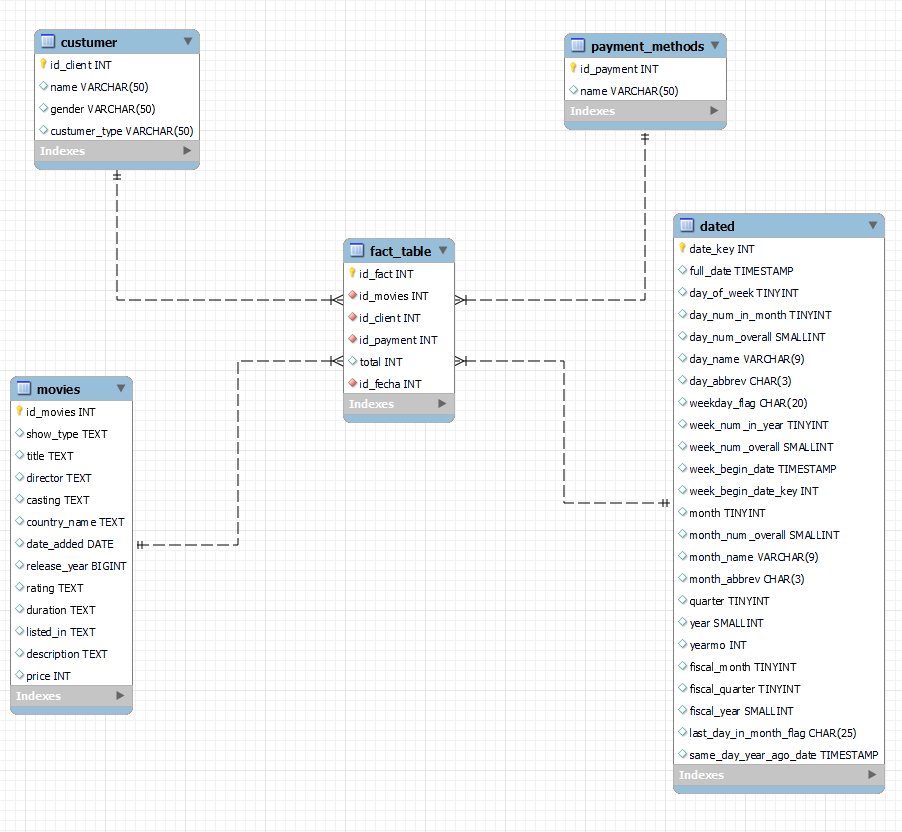

In [ ]:
import create_dw_que
try:
    myDw = mysqlC.connect(
    host=RDS_DW_HOST, 
    user=config.get('RDS_MYSQL', 'DB_USER'),
    password=config.get('RDS_MYSQL', 'DB_PASSWORD'),
    database=config.get('RDS_MYSQL', 'DB_NAME')
    )
    mycursor = myDw.cursor()
    tablas = create_dw_que.CREATE_DW.split(';')
    for tabla in tablas:     
        tabla = re.sub('[\n\r]', '', tabla)
        if len(tabla) > 1:
            mycursor.execute(tabla)
    myDw.commit()
    print("Data Warehouse Creado Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Data Warehouse Creado Exitosamente


Poblamos las tablas del DW

In [ ]:
mysql_driver = f"""mysql+pymysql://{config.get('RDS_MYSQL', 'DB_USER')}:{config.get('RDS_MYSQL', 'DB_PASSWORD')}@{RDS_DW_HOST}:{config.get('RDS_MYSQL', 'DB_PORT')}/{config.get('RDS_MYSQL', 'DB_NAME')}"""  

##Insertamos Custumers

In [ ]:
dim_custumer.to_sql('custumer', mysql_driver, index=False, if_exists='append', method='multi')

300

##Insertamos las Movies

In [ ]:
dim_movies.to_sql('movies', mysql_driver,  index=False, if_exists='append', method='multi')

8807

##Insertamos las Fechas

In [ ]:
dim_fecha.to_sql('dated', mysql_driver, index=False, if_exists='append')

2191

##Insertamos los payment_methods

In [ ]:
dim_payment_methods.to_sql('payment_methods',mysql_driver, index=False, if_exists='append', method='multi')

3

##Insertamos la fact_table

In [ ]:
df_factTable.to_sql('fact_table', mysql_driver, index=False, if_exists='append', method='multi')

589

# Análisis de datos



## 1. ¿Cuales son las ventas mensuales?

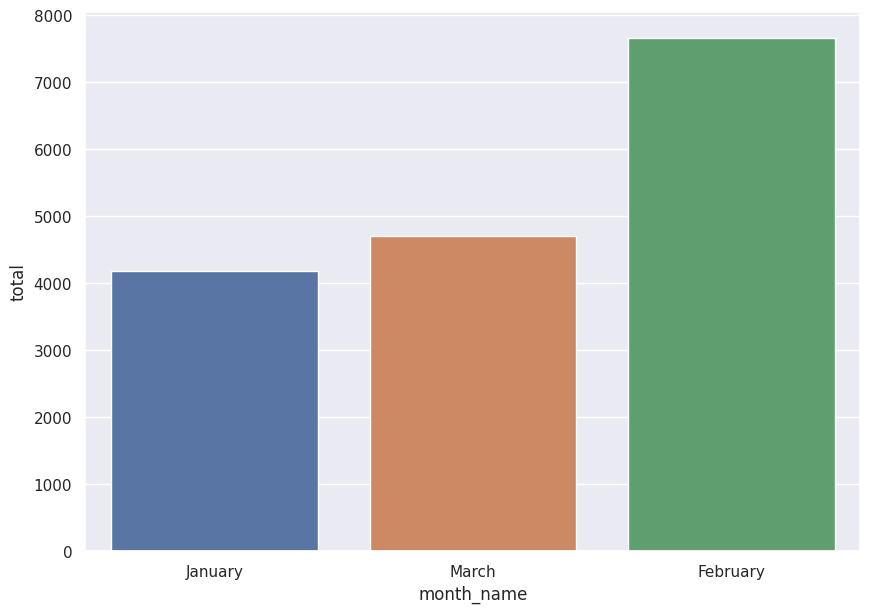

In [ ]:
sns.set(rc={'figure.figsize':(10,7)})
df_factTable['id_fecha'] = df_factTable['id_fecha'].astype('int64')
df_ventas_fecha = df_factTable.merge(dim_fecha, how='inner', left_on='id_fecha', right_on='date_key')
dataSetN = df_ventas_fecha.groupby(['month_num_overall', 'month_name'], as_index=False).sum('total').sort_values('total')
graph = sns.barplot(x=dataSetN['month_name'], y=dataSetN['total'])
plt.show()

## 2. ¿Que tipo de cliente es el que más compra?

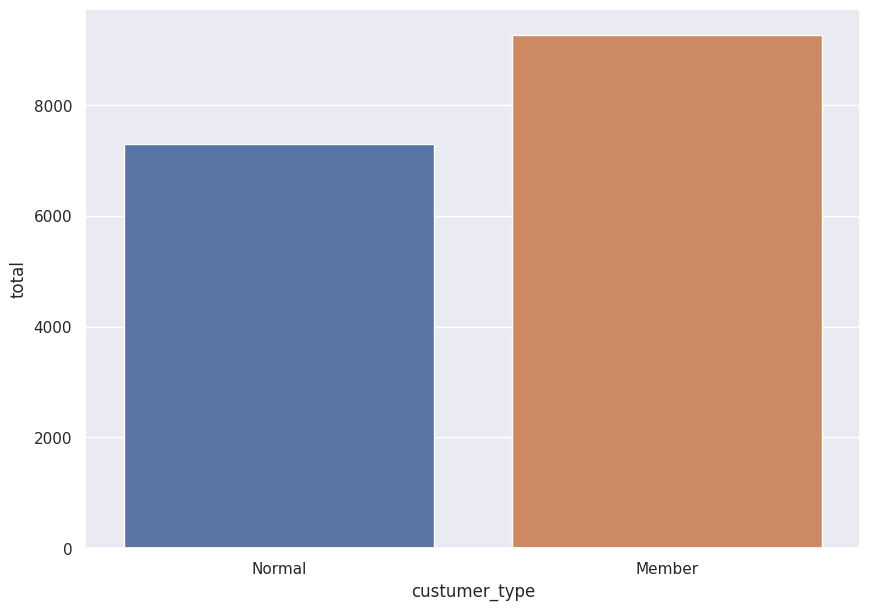

In [ ]:
df_ventas_fecha_clientes = df_ventas_fecha.merge(dim_custumer, how='inner', on='id_client')
df_ventas_fecha_clientes_f = df_ventas_fecha_clientes.groupby('custumer_type', as_index=False).sum('total').sort_values('total')
graph = sns.barplot(x=df_ventas_fecha_clientes_f['custumer_type'], y=df_ventas_fecha_clientes_f['total'])
plt.show()

## 3. ¿Que tipo de show de TV o Pelicula es mas comprado?

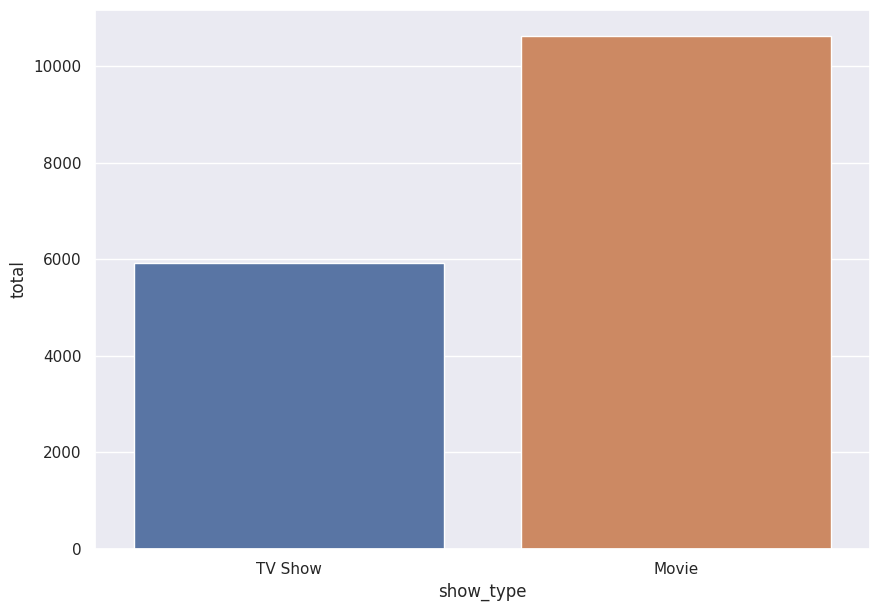

In [ ]:
df_ventas_movies = df_factTable.merge(dim_movies, how='inner', on='id_movies')
df_ventas_movies_f = df_ventas_movies.groupby('show_type', as_index=False).sum('total').sort_values('total')
graph = sns.barplot(x=df_ventas_movies_f['show_type'], y=df_ventas_movies_f['total'])
plt.show()

## 4. ¿Que tipo de categoría de show es el mas vendido?

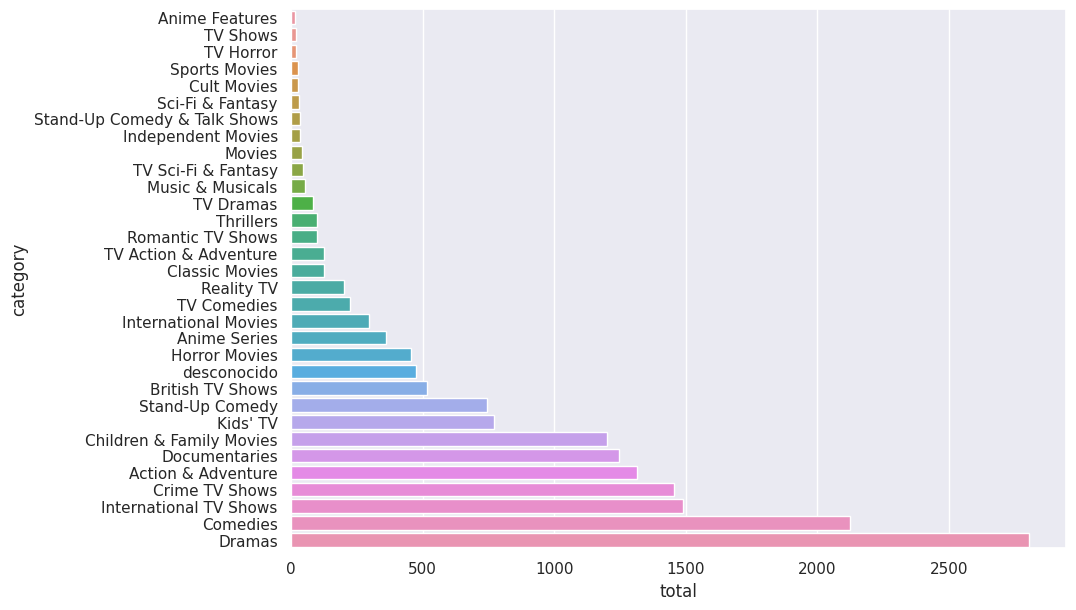

In [ ]:
df_ventas_movies_l = df_ventas_movies.groupby(['category', 'show_type'], as_index=False).sum('total').sort_values('total')
df_ventas_movies_l
graph = sns.barplot(x=df_ventas_movies_l['total'], y=df_ventas_movies_l['category'])
plt.show()

## 5. ¿Cuales son los 10 clientes mas frecuentes?

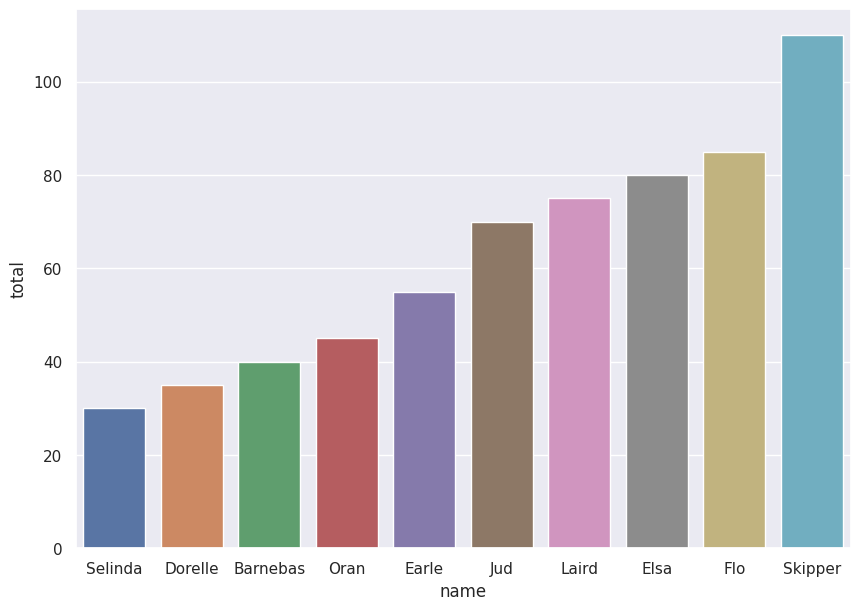

In [ ]:
df_clientes_frec = df_ventas_fecha_clientes.groupby(['id_client', 'name'], as_index=False).sum('total').sample(n=10).sort_values('total')
graph = sns.barplot(x=df_clientes_frec['name'], y=df_clientes_frec['total'])
plt.show()

## 6. ¿Qué metodo de pago es el más requerido por los clientes?

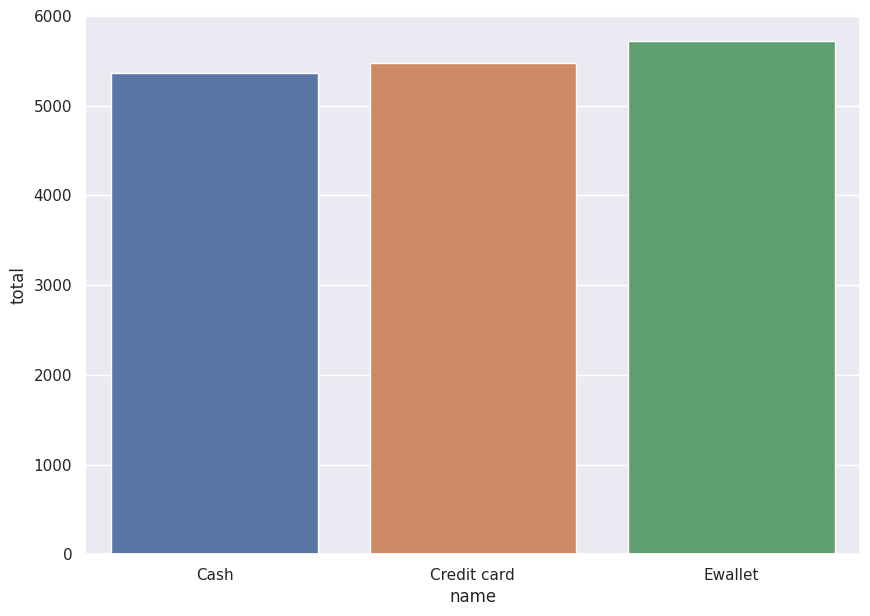

In [ ]:
df_ventas_pago = df_factTable.merge(dim_payment_methods, how='inner', on='id_payment')
df_ventas_pago_f = df_ventas_pago.groupby(['id_payment', 'name'], as_index=False).sum('total').sort_values('total')
graph = sns.barplot(x=df_ventas_pago_f['name'], y=df_ventas_pago_f['total'])
plt.show()

### 7. Comparación de peliculas o programas por su clasificacion de edad comprados por Hombres y Mujeres

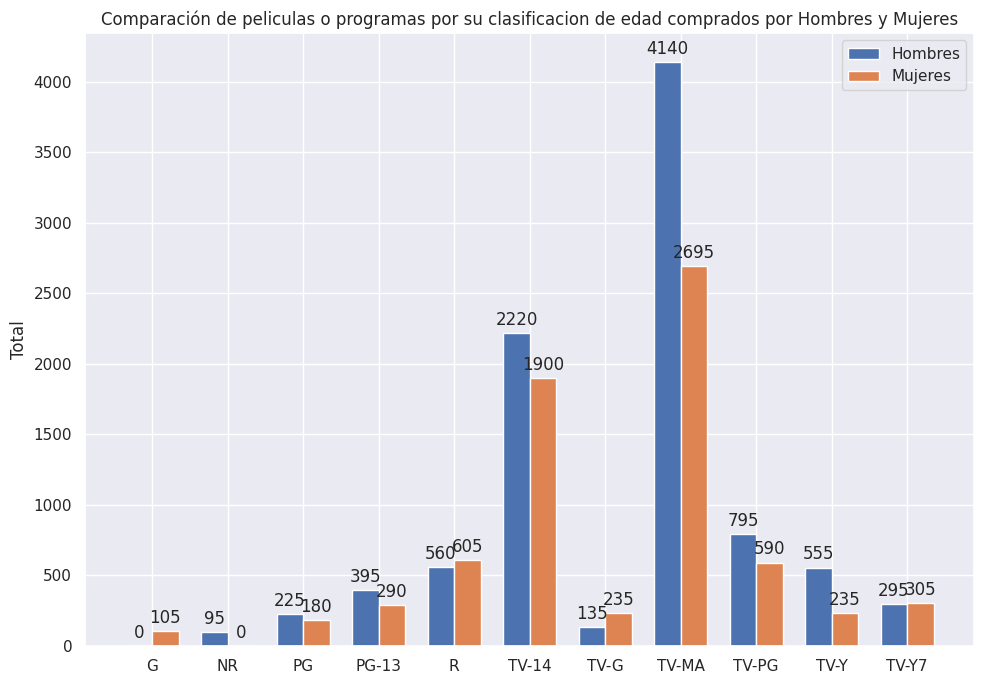

In [ ]:
df_movies_fecha_cliente = df_ventas_fecha_clientes.merge(dim_movies, how='inner', on='id_movies')
df_movies_fecha_cliente.columns.tolist()

df_rating= df_movies_fecha_cliente.groupby(['rating'], as_index=False).sum()['rating']
df_hombres_mujeres = df_movies_fecha_cliente.pivot_table(index='rating', 
                     columns='gender', 
                     values='total',
                     fill_value=0, 
                     aggfunc='sum').unstack()
#clasificacion de rangos que pertenecen a cada genero
mujeres = df_hombres_mujeres[:(int(len(df_hombres_mujeres)/2))].tolist() 
hombres = df_hombres_mujeres[(int(len(df_hombres_mujeres)/2)):].tolist() 

x = np.arange(len(df_rating))
#tamaño de cada barra
width = 0.35

fig, ax = plt.subplots()
#Generamos las barras para el conjunto de hombres
rects1 = ax.bar(x - width/2, hombres, width, label='Hombres')
#Generamos las barras para el conjunto de mujeres
rects2 = ax.bar(x + width/2, mujeres, width, label='Mujeres')

ax.set_ylabel('Total')
ax.set_title('Comparación de peliculas o programas por su clasificacion de edad comprados por Hombres y Mujeres')
ax.set_xticks(x)
ax.set_xticklabels(df_rating)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
#Añadimos las etiquetas para cada barra
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()